# Term Project - Milestone #2

Simon Aytes

MAT 328 - Techniques in Data Science

Spring 2022

Professor Owen

----

# 0. Environment configuration

## 0.1 Import libraries

In [ ]:
# IMPORTANT: If you do not already have the libraries installed, run this cell to install them
!pip install -r requirements.txt

In [1]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Feature selection
from sklearn.feature_selection import RFE

# Visualization
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

# Environment setup
%matplotlib inline
pd.set_option('display.max_columns', None)

## 0.2 Utility functions

The function below uses [RFE Feature Elimination](https://machinelearningmastery.com/rfe-feature-selection-in-python/) to determine the optimal features for our models. It is set up as a dynamic function that can be used by either model and, as such, is used for both to determine their inputs.

In [2]:
def rfe_selection(model, data):
    # Assign data-related variables
    features = ["age", "sex", "is_smoking", "cigsPerDay", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose", "TenYearCHD"]
    df_vals = data.values

    # Identify the column names of the features
    inputs = df_vals[:,0:len(features)-1]
    response_variable = df_vals[:,len(features)-1]

    # Feature extraction
    #dt_classifier = DecisionTreeClassifier(max_depth = 5)
    rfe = RFE(model, step = 3)
    fit = rfe.fit(inputs, response_variable)

    # Create list with the target feature names
    selected_features = list(np.array(features[:-1])[np.array(fit.support_)])
    
    # Return a list containing the column names of the most relevant features
    return selected_features

# 1. Load processed data
----

In [17]:
# Get path to the repository's data folder
data_path = "/".join(os.getcwd().split("/")[0:-1]) + "/data/"

In [18]:
chd = pd.read_csv(open(data_path + "processed/data_cleaned.csv"))
chd = chd.drop(columns=["Unnamed: 0"]) # Drop the index column

In [19]:
chd.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,36,4,1,0,0.0,0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0.0
1,2,46,1,0,1,10.0,0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0.0
2,3,50,1,1,1,20.0,0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1.0
3,4,64,1,0,1,30.0,0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0.0
4,5,61,3,0,0,0.0,0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1.0


# 2. Preparing the data

----

## 2.1 Normalizing the data

The data is currently a mix of binary and continuous values. When using such a dataset to make classifications, the disparate scales of the data can increase model error. 

To address this, we will use a min-max scaler to normalize all of the model inputs. The equation for min-max scaling is shown below, where $X_{scaled}$ is the scaled value of $X$ given a particular dataset.

$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

In [7]:
scaler = MinMaxScaler()

In [8]:
# Scale values (All except the 'id' column, as it will not be used in analysis)
chd = scaler.fit_transform(chd)
chd = pd.DataFrame(chd)

# Re-assign column names
column_names = chd.columns.to_list() #Preserve old column name
chd.columns = column_names #Rename columns to old labels

# Drop the 'id' and 'education' columns
chd = chd.drop(columns=["id", "education"])

In [9]:
chd.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0.105263,1.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.203285,0.399527,0.529101,0.338149,0.275510,0.098870,0.0
1,0.368421,0.0,1.0,0.142857,0.0,0.0,0.0,0.0,0.281314,0.153664,0.243386,0.107493,0.438776,0.152542,0.0
2,0.473684,1.0,1.0,0.285714,0.0,0.0,1.0,0.0,0.246407,0.352246,0.423280,0.301175,0.234694,0.152542,1.0
3,0.842105,0.0,1.0,0.428571,0.0,0.0,0.0,0.0,0.262834,0.250591,0.391534,0.256121,0.255102,0.104520,0.0
4,0.763158,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.326489,0.465721,0.772487,0.412341,0.408163,0.070621,1.0


# 2.2 Outlier detection and removal

For our model data, we want to remove any outliers within the continuous columns of our data. To do this we will use Interquartile Ranges (IQR) and, more specifically, values that lie outside of the following boundary: $(Q_{1} - 1.5) * IQR ≤ x ≤ (Q_{3} + 1.5) * IQR$.

This boundary and the relationship of outliers to the dataset can be seen in the image below.

<center>
<img src="Figures/boxplot_outliers.png" width=500 height=50 />
</center>
<center>
<em><a href="https://www.simplypsychology.org/boxplots.html#:~:text=When%20reviewing%20a%20box%20plot,whiskers%20of%20the%20box%20plot.&text=For%20example%2C%20outside%201.5%20times,Q3%20%2B%201.5%20*%20IQR).">Image source</a></em>
</center>

In [20]:
# Identify numerical columns
numerical_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

# Gather quantile information
Q1 = chd[numerical_columns].quantile(0.25)
Q3 = chd[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers by filtering to be within the range outlined above
chd_filtered = chd[~((chd[numerical_columns] < (Q1 - 1.5 * IQR)) | (chd[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [21]:
num_outliers = chd.shape[0] - chd_filtered.shape[0]

print(f"A total of {num_outliers} were removed from the scaled datatset.")

A total of 365 were removed from the scaled datatset.


# 3. Decision Tree Classifier

----

## 3.1 Determine ideal depth and model inputs

To determine the ideal model depth for the training data, we will loop through multiple depths ($2 ≤ d ≤ 10$) to see which one has the lowest error. 

Within each loop we will utilize [RFE Feature Elimination](https://machinelearningmastery.com/rfe-feature-selection-in-python/) to determine our inputs and ensure that we are getting the best possible results.

In [22]:
# Create empty lists
depth_list = []
model_error = []

# Split data before evaluation for consistency in results
dt_x = chd_filtered.drop(columns = ["TenYearCHD"]) #Use columns identified above
dt_y = chd_filtered[["TenYearCHD"]]

dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_x, dt_y, test_size=0.2)

# Loop through each depth
for d in range(2,11):
    # Append the depth to the list
    depth_list.append(d)
    
    # Create model input lists
    dt_selected_features = rfe_selection(model = DecisionTreeClassifier(max_depth = d), data = chd_filtered) #Find most relevant model inputs
    
    # Create and fit model
    dt_classifier = DecisionTreeClassifier(max_depth = d)
    dt_classifier = dt_classifier.fit(dt_x_train[chd_filtered.columns.intersection(dt_selected_features)], dt_y_train)
    
    # Test model and log error
    dt_y_pred = dt_classifier.predict(dt_x_test[chd_filtered.columns.intersection(dt_selected_features)])
    model_error.append(accuracy_score(dt_y_pred, dt_y_test))

Text(0, 0.5, 'Accuracy')

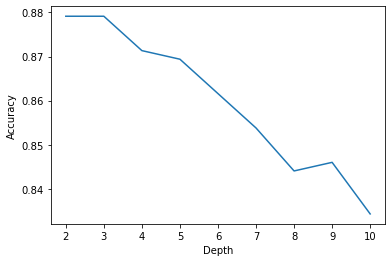

In [23]:
plt.plot(depth_list, model_error)
plt.xlabel("Depth")
plt.ylabel("Accuracy")

From the above plot, we can see the accuracy scores at each tested depth. The highest point on the graph corresponds to the ideal depth of the model.

We can access this value by using the following list comprehension: `depth_list[model_error.index(max(model_error))]`

This code will identify the index of the maximum value in the `model_error` list which stores the accuracy scores and locate the corresponding value in the `depth_list` list.

In [24]:
# Identify most-relevant model features
dt_selected_features = rfe_selection(model = DecisionTreeClassifier(max_depth = depth_list[model_error.index(max(model_error))]), data = chd_filtered) #Find most relevant model inputs

# Split the data into x and y
dt_x = chd_filtered[chd_filtered.columns.intersection(dt_selected_features)] #Use columns identified above
dt_y = chd_filtered[["TenYearCHD"]]

In [25]:
dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_x, dt_y, test_size=0.2)

## 3.2 Create decision tree classifier

In [26]:
# Create classifier with a depth equal to that of the lowest error
dt_classifier = DecisionTreeClassifier(max_depth = depth_list[model_error.index(max(model_error))])

# Fit the classifier with the training data
dt_classifier = dt_classifier.fit(dt_x_train, dt_y_train)

[Text(581.25, 943.75, 'X[0] <= 55.5\ngini = 0.235\nsamples = 2049\nvalue = [1770, 279]'),
 Text(290.625, 566.25, 'X[2] <= 157.75\ngini = 0.178\nsamples = 1552\nvalue = [1399, 153]'),
 Text(145.3125, 188.75, 'gini = 0.162\nsamples = 1467\nvalue = [1337, 130]'),
 Text(435.9375, 188.75, 'gini = 0.395\nsamples = 85\nvalue = [62, 23]'),
 Text(871.875, 566.25, 'X[2] <= 145.5\ngini = 0.378\nsamples = 497\nvalue = [371, 126]'),
 Text(726.5625, 188.75, 'gini = 0.328\nsamples = 319\nvalue = [253, 66]'),
 Text(1017.1875, 188.75, 'gini = 0.447\nsamples = 178\nvalue = [118, 60]')]

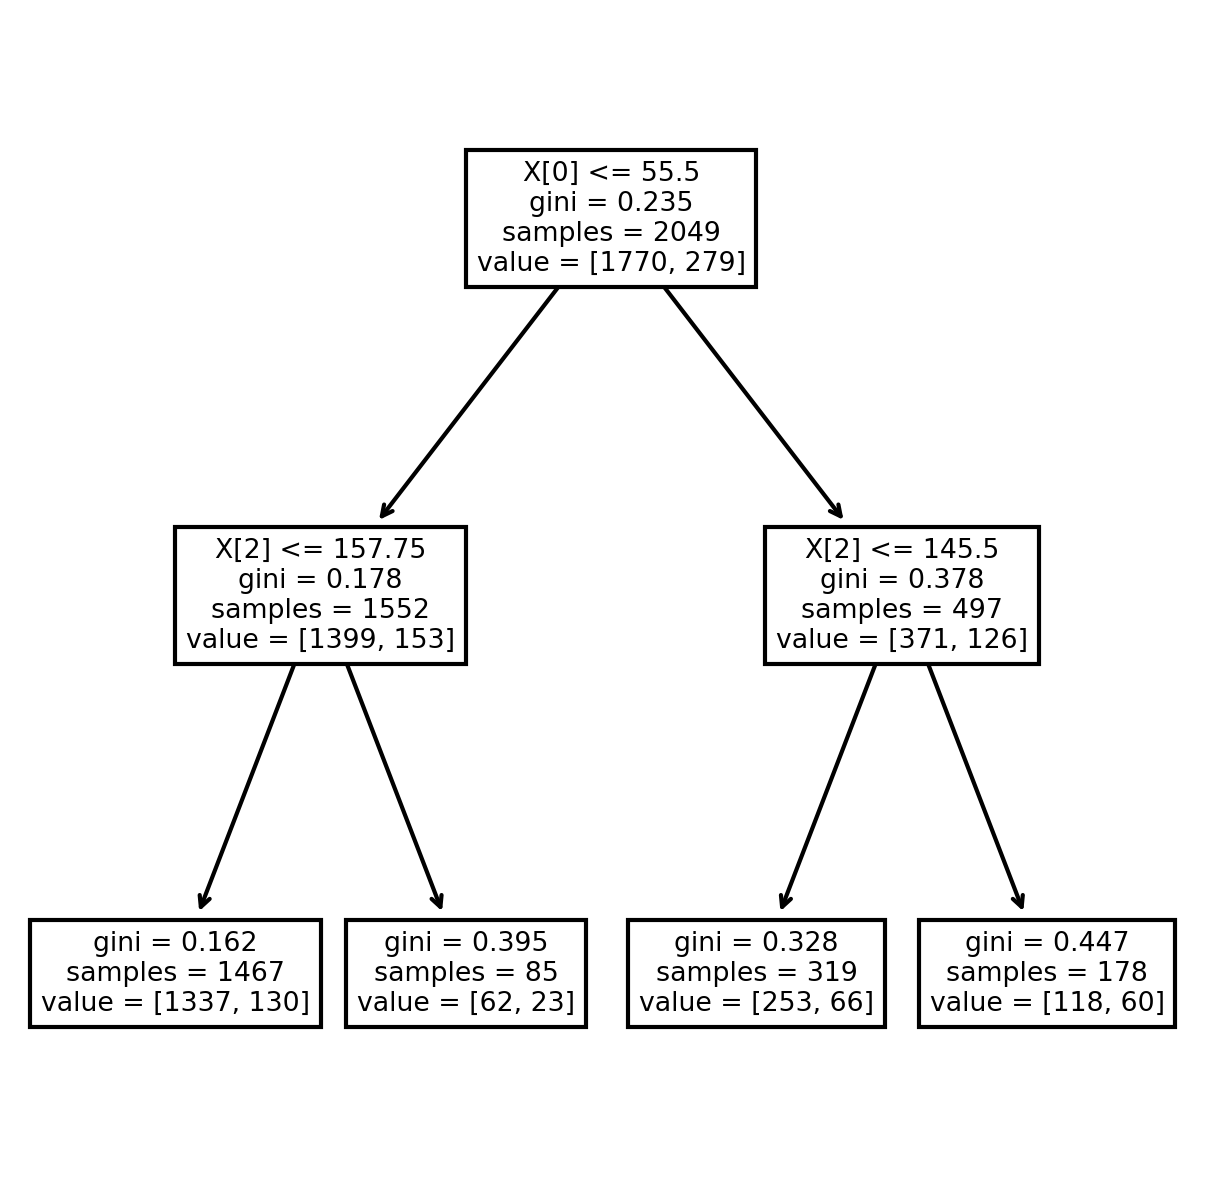

In [27]:
### OPTIONAL ###
# Visualize decision tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)
plot_tree(dt_classifier)

## 3.3 Evaluate model performance

In [28]:
# Predict test data with classifier
dt_y_pred_test = dt_classifier.predict(dt_x_test)

In [29]:
# Calculate the accuracy of the model
dt_classifier_accuracy = accuracy_score(dt_y_pred_test, dt_y_test)

# Output MSE
print(f"Decision Tree Regressor Accuracy (d={depth_list[model_error.index(max(model_error))]}): {dt_classifier_accuracy}")

Decision Tree Regressor Accuracy (d=2): 0.8810916179337231


In [30]:
# Create a confusion matrix of the results
dt_cm = confusion_matrix(dt_y_test, dt_y_pred_test)

print(f"""
CONFUSION MATRIX RESULTS
True Negatives: {dt_cm[0,0]}
True Positives: {dt_cm[1,1]}

False Negatives: {dt_cm[0,1]}
False Positives: {dt_cm[1,0]}
""")


CONFUSION MATRIX RESULTS
True Negatives: 452
True Positives: 0

False Negatives: 0
False Positives: 61



# 4. Logistic Regression Classifier

----

## 4.1 Feature selection

First we have to determine the ideal inputs for the model. To determine this, we will use [RFE Feature Elimination](https://machinelearningmastery.com/rfe-feature-selection-in-python/). 

In [33]:
lr_selected_features = rfe_selection(model = LogisticRegression(), data = chd_filtered)

/Users/simon/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/simon/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [35]:
lr_selected_features

['age', 'sex', 'prevalentStroke', 'diaBP', 'BMI', 'heartRate', 'glucose']

From the above RFE results, we can see that the seven most relevant variables are; `age`, `sex`, `cigsPerDay`, `prevalentStroke`, `totChol`, `sysBP`, and `glucose`. 

These seven features will be our inputs for this model.

In [36]:
# Split the data into x and y
lr_x = chd_filtered[chd_filtered.columns.intersection(lr_selected_features)] #Use columns identified above
lr_y = chd_filtered[["TenYearCHD"]]

In [37]:
lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(lr_x, lr_y, test_size=0.2)

## 4.2 Create logistic regressor

In [38]:
lr_model = LogisticRegression()
lr_model = lr_model.fit(lr_x_train, lr_y_train.values.ravel())

/Users/simon/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
lr_model_predicted = lr_model.predict(lr_x_test)

## 4.3 Evaluate model performance

In [40]:
# Create a confusion matrix of the results
lr_cm = confusion_matrix(lr_model_predicted, lr_y_test)

print(f"""
CONFUSION MATRIX RESULTS
True Negatives: {lr_cm[0,0]}
True Positives: {lr_cm[1,1]}

False Negatives: {lr_cm[0,1]}
False Positives: {lr_cm[1,0]}
""")


CONFUSION MATRIX RESULTS
True Negatives: 445
True Positives: 0

False Negatives: 68
False Positives: 0



In [41]:
# Calculate the accuracy of the model
lr_model_accuracy = accuracy_score(lr_model_predicted, lr_y_test)

# Output accuracy
print(f"Logistic Regressor Accuracy: {lr_model_accuracy}")

Logistic Regressor Accuracy: 0.8674463937621832


# 5. Results

----

## 5.1 Accuracy scores

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

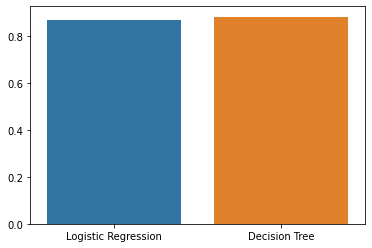

In [42]:
accuracy_vals = list()
accuracy_vals.append(lr_model_accuracy)
accuracy_vals.append(dt_classifier_accuracy)
model_names = ["Logistic Regression", "Decision Tree"]

ax = sns.barplot(x=model_names, y=accuracy_vals)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("Accuracy Score Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
ax.bar_label(ax.containers[0])
plt.show()

## 5.2 Confusion matrix

When evaluating a classification model, the context is very important. Even if the accuracy score is high, that only tells you how often a model correctly classifies something, but it does not tell you _what_ it is correctly classifying.

In the context of this project, we are looking at medical data. Given the nature of medical diagnoses, errors in classification (misdiagnoses) fall into two categories of errors:

> __Type I Error:__ Reject the null hypothesis when it's actually true (false negative)

> __Type II Error:__ Fail to reject the null hypothesis when it's actually false (false positive)

Type II errors are always worse than Type I errors. In this context, a false negative could mean leading a patient to think that they are healthy when, in fact, they have developed a fatal disease that is time sensitive and could otherwise be treated.

For our final evaluation of these models, we will look at the breakdown of Type I and Type II errors across the classifiers tested.

In [43]:
print(f"""
CORRECT CLASSIFICATIONS
\t\tLogistic Regression\tDecision Tree
NEGATIVES: \t{lr_cm[0,0]}\t\t\t{dt_cm[0,0]}
POSITIVES: \t{lr_cm[1,1]}\t\t\t{dt_cm[1,1]}

ERROR BREAKDOWN
\t\tLogistic Regression\tDecision Tree
TYPE I: \t{lr_cm[0,1]}\t\t\t{dt_cm[0,1]}
TYPE II: \t{lr_cm[1,0]}\t\t\t{dt_cm[1,0]}
""")


CORRECT CLASSIFICATIONS
		Logistic Regression	Decision Tree
NEGATIVES: 	445			452
POSITIVES: 	0			0

ERROR BREAKDOWN
		Logistic Regression	Decision Tree
TYPE I: 	68			0
TYPE II: 	0			61

